## Info

When the COVID-19 crisis first entered the U.S. and even up through the first spike in cases, I was too anxious to really post anything related to it. Now that we're clearly going into the "second peak" phase, might as well add to the projects.

### The Work

We will take a look at the cases and deaths as reported through Johns Hopkis data and produce simple plots for the US in both of those instances. Then we will examine only NEW cases from a statistical and forecasting point. Finally we will try out this **STUMPY** package and examine the matrix profile of the new cases.


### Notes:

- Rerun at 8/13/2020 but capping forecast at 7/24.
- Rerun on 10/31 encompassing the past and most recent trends but keeping the forecast point at 7/24. Additionally adding in a 7 day moving average as a different look into a forecasting procedure.
- Adding a few items and also the APs call for the presidential race.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sma
from scipy import stats
import stumpy
import pmdarima as pmd

from tqdm import tqdm_notebook
from collections import Counter
import seaborn as sns

import datetime as dt
import gc
import os
import warnings

%matplotlib inline

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Current Cases

Pulled from Johns Hopkins.

In [2]:
url = '''https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'''

dfc = pd.read_csv(url)

In [3]:
print(dfc.shape)
dfc.head()

(269, 298)


Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
0        0        0        0        0        0        0        1        1   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        1   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  \
0        1        1        1        1       1       1       1       1       1   
1        0        0        0        0       0       0       0       0       0   
2        1        1        1        1       1       3       5      12      12   
3        0        0        0        0       0       1       1       1       1   
4        0        0        0        0       0       0       0       0       0   

   3/6/20  3/7/20  ...  9/22/20  9/23/20  9/24/20  9/25/20  9/26/20  9/27/20  \
0       1       1  ...    39096    39145    39170    39186    39192    39227   
1       0       0  ...    12666    12787    12921    13045    13153    13259   
2      17      17  ...    50214    50400    50579    50754    50914    51067   
3       1       1  ...     1681     1753     1753     1836     1836     1836   
4       0       0  ...     4236     4363     4475     4590     4672     4718   

   9/28/20  9/29/20  9/30/20  10/1/20  10/2/20  10/3/20  10/4/20  10/5/20  \
0    39233    39254    39268    39285    39290    39297    39341    39422   
1    13391    13518    13649    13806    13965    14117    14266    14410   
2    51213    51368    51530    51690    51847    51995    52136    52270   
3     1966     1966     2050     2050     2110     2110     2110     2370   
4     4797     4905     4972     5114     5211     5370     5402     5530   

   10/6/20  10/7/20  10/8/20  10/9/20  10/10/20  10/11/20  10/12/20  10/13/20  \
0    39486    39548    39616    39693     39703     39799     39870     39928   
1    14568    14730    14899    15066     15231     15399     15570     15752   
2    52399    52520    52658   

In [4]:
# dfc[dfc['Country/Region'].str.contains("US")]
usc = dfc[dfc['Country/Region'].str.contains("US")].drop(['Province/State','Country/Region','Lat','Long'],
                                                         axis=1).T
usc = pd.DataFrame(usc)
usc.columns = ['us_cases']
print(usc.shape)
usc.index = pd.to_datetime(usc.index)
usc.head()

(294, 1)


us_cases
2020-01-22         1
2020-01-23         1
2020-01-24         2
2020-01-25         2
2020-01-26         5

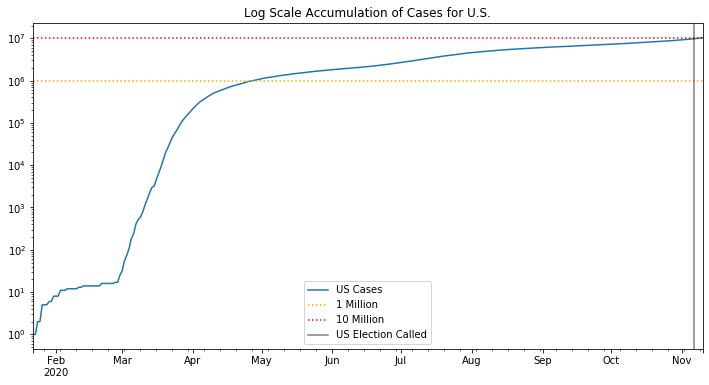

In [9]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
usc.plot(ax=ax);
ax.set_title("Log Scale Accumulation of Cases for U.S.");
ax.axhline(1e6, color='orange', ls=':')
ax.axhline(1e7, color='r', ls=':')
ax.axvline('2020-11-06', color='k', alpha=0.5);
ax.set_yscale("log");
ax.legend(['US Cases','1 Million','10 Million','US Election Called']);

In [10]:
usc.tail().style.format('{:,.0f}')

**Since our last update we have surpassed the 1 million case mark and are steadily approaching the 10 million case mark.**

### Current Deaths

Also pulled from Johns Hopkins.

In [11]:
url = '''https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'''

dfd = pd.read_csv(url)

In [12]:
print(dfd.shape)
dfd.head()

(269, 298)


Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  1/29/20  1/30/20  1/31/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/1/20  2/2/20  2/3/20  2/4/20  2/5/20  2/6/20  2/7/20  2/8/20  2/9/20  \
0       0       0       0       0       0       0       0       0       0   
1       0       0       0       0       0       0       0       0       0   
2       0       0       0       0       0       0       0       0       0   
3       0       0       0       0       0       0       0       0       0   
4       0       0       0       0       0       0       0       0       0   

   2/10/20  2/11/20  2/12/20  2/13/20  2/14/20  2/15/20  2/16/20  2/17/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/18/20  2/19/20  2/20/20  2/21/20  2/22/20  2/23/20  2/24/20  2/25/20  \
0        0        0        0        0        0        0        0        0   
1        0        0        0        0        0        0        0        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        0        0        0        0        0        0   

   2/26/20  2/27/20  2/28/20  2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  \
0        0        0        0        0       0       0       0       0       0   
1        0        0        0        0       0       0       0       0       0   
2        0        0        0        0       0       0       0       0       0   
3        0        0        0        0       0       0       0       0       0   
4        0        0        0        0       0       0       0       0       0   

   3/6/20  3/7/20  ...  9/22/20  9/23/20  9/24/20  9/25/20  9/26/20  9/27/20  \
0       0       0  ...     1445     1446     1451     1451     1453     1453   
1       0       0  ...      367      370      370      373      375      377   
2       0       0  ...     1689     1698     1703     1707     1711     1714   
3       0       0  ...       53       53       53       53       53       53   
4       0       0  ...      155      159      162      167      171      174   

   9/28/20  9/29/20  9/30/20  10/1/20  10/2/20  10/3/20  10/4/20  10/5/20  \
0     1455     1458     1458     1458     1458     1462     1462     1466   
1      380      384      387      388      389      392      396      400   
2     1719     1726     1736     1741     1749     1756     1760     1768   
3       53       53       53       53       53       53       53       53   
4      176      179      183      185      189      193      195      199   

   10/6/20  10/7/20  10/8/20  10/9/20  10/10/20  10/11/20  10/12/20  10/13/20  \
0     1467     1469     1470     1472      1473      1477      1479      1480   
1      403      407      411      413       416       420       424       429   
2     1768     1771     1783   

In [13]:

usd = dfd[dfd['Country/Region'].str.contains("US")].drop(['Province/State','Country/Region','Lat','Long'],
                                                         axis=1).T
usd = pd.DataFrame(usd)
usd.columns = ['us_deaths']
print(usd.shape)
usd.index = pd.to_datetime(usd.index)
usd.head()

(294, 1)


us_deaths
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0

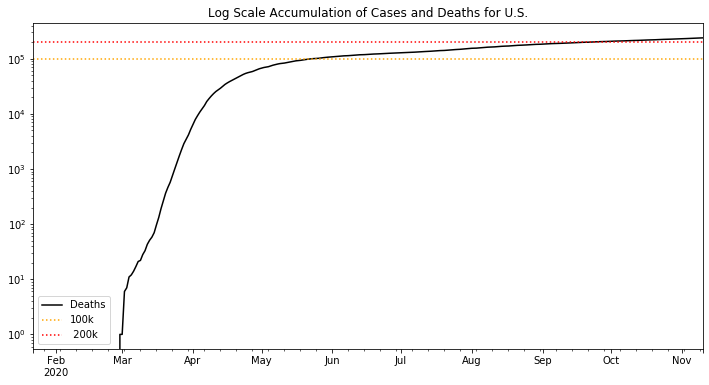

In [14]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
# usc.plot(ax=ax);
usd.plot(ax=ax, style='k-');
ax.axhline(100000, color='orange', linestyle=':')
ax.axhline(200000, color='red', linestyle=':')
ax.set_title("Log Scale Accumulation of Cases and Deaths for U.S.");
ax.set_yscale("log");
ax.legend(['Deaths','100k',' 200k']);

In [15]:
usd.tail().style.format('{:,.0f}')

**We have passed 200 k deaths.**

### New Cases

We can define the new cases but taking the first difference of the cases. A simple check can show us that we have it right.

In [16]:
usc['new_cases'] = usc.us_cases.diff()
usc.head(10)

us_cases  new_cases
2020-01-22         1        NaN
2020-01-23         1        0.0
2020-01-24         2        1.0
2020-01-25         2        0.0
2020-01-26         5        3.0
2020-01-27         5        0.0
2020-01-28         5        0.0
2020-01-29         6        1.0
2020-01-30         6        0.0
2020-01-31         8        2.0

Yes, the first difference appears to work for defining new cases.

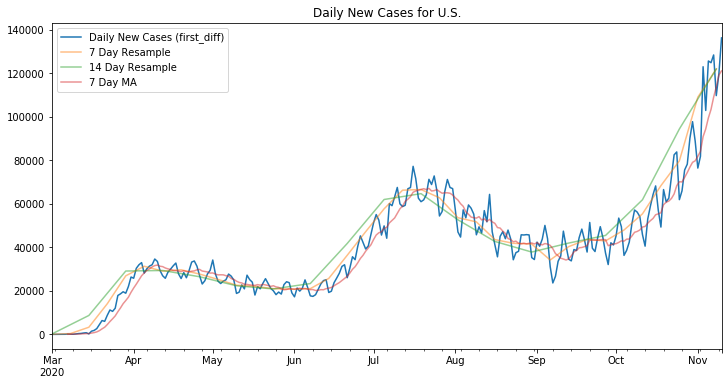

In [17]:
fig, ax=plt.subplots(1,1,figsize=(12,6))
usc.new_cases.loc['2020-03-01':].plot(ax=ax);
usc.new_cases.loc['2020-03-01':].resample('7D').mean().plot(ax=ax, alpha=0.5);
usc.new_cases.loc['2020-03-01':].resample('14D').mean().plot(ax=ax, alpha=0.5);
usc.new_cases.loc['2020-03-01':].rolling(7).mean().plot(ax=ax, alpha=0.5);
ax.set_title("Daily New Cases for U.S.");
plt.legend(['Daily New Cases (first_diff)','7 Day Resample','14 Day Resample','7 Day MA']);

Using the first difference we manage to get the daily new case counts, and I added the 7 and 14 day resampled means since there is underlying structure with the way the counts are recorded and the apparent incubation period.

I also started the plot from March 1st since that is when things really started picking up according to the data collection.

**Update - 2020-11-7:** The past week has seen the largest increases since the start of the pandemic.

### Forecasting the New Cases

We are using a training set of data up to July 24 2020.

In [18]:
train_end = '2020-07-24'
y = usc.us_cases.loc['2020-03-01':train_end].diff().dropna()

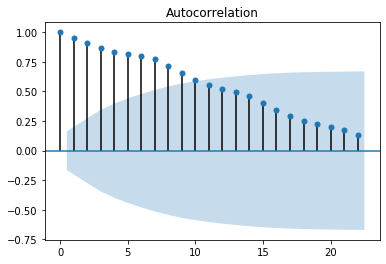

In [19]:
# pmd.plot_acf(y);
sma.tsa.graphics.plot_acf(y);

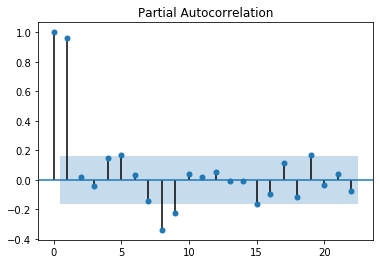

In [20]:
# pmd.plot_pacf(y);
sma.tsa.graphics.plot_pacf(y);

It appears there is serial correlation at 1,7,8, and 9 lags at least.

In [21]:
## this is an auto arima method that focuses on the AIC score optimization

arima = pmd.auto_arima(y=y, max_p=21, max_d=1, max_q=21, seasonal = True, m=7, out_of_sample_size=14)
print(arima.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  145
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1345.811
Date:                             Wed, 11 Nov 2020   AIC                           2701.622
Time:                                     10:17:47   BIC                           2716.471
Sample:                                          0   HQIC                          2707.656
                                             - 145                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    116.7218    117.417      0.994      0.320    -113.411     346.854
ar.L1         -0.4197      

**The original model comes out with difference on our already differenced data. As well as AutoRegressive terms on lags 1 2 and 3, and moving averages across 1 and 2 lags.** 

The variables are all significant but the large sigma term suggests we are missing a lot of variance.

We also set 14 days for an out of sample test to confirm the best model.

In [22]:
# mod = sma.tsa.SARIMAX(endog=y, order=(1,1,0), seasonal_order=(1,0,1,7), trend='c')
mod = sma.tsa.SARIMAX(endog=y, order=(3,1,2), seasonal_order=(1,0,[],7), trend='c')
fit = mod.fit()
print(fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           us_cases   No. Observations:                  145
Model:             SARIMAX(3, 1, 2)x(1, 0, [], 7)   Log Likelihood               -1347.899
Date:                            Wed, 11 Nov 2020   AIC                           2711.799
Time:                                    10:17:47   BIC                           2735.557
Sample:                                03-02-2020   HQIC                          2721.453
                                     - 07-24-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    797.3320    278.692      2.861      0.004     251.105    1343.559
ar.L1          0.7650      0.100   

We re-run the model outside of the ARIMA and we can consider this our final model which we can forecast on. All of the variables remain significant as well which is a good sign.

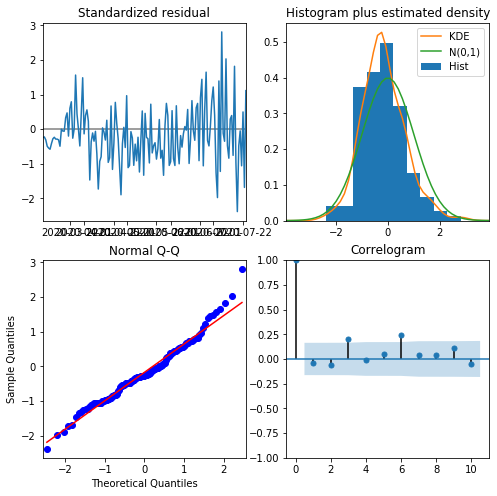

In [23]:
fit.plot_diagnostics(figsize=(8,8));

There appears there is still some serial correlation existent in the residual even at a second difference. Though the errors appear normal.

The QQ Plot highlights that our model is a fairly good fit.

In [24]:
## Lets forecast out a month based on this data
days_to_forecast = 120
forecast = fit.get_forecast(days_to_forecast)
f_mean = forecast.predicted_mean
ci = forecast.conf_int()
pred = fit.predict()

**In addition to this model above, I am working with one that has AR terms on 1,6,7 and 14.**

In [25]:
arimod_simple = sma.tsa.SARIMAX(endog=y, order=([1,0,0,0,0,1,1,0,0,0,0,0,0,1],1,0), trend='c',
                                      seasonal_order=(0,1,0,7))
fit_simple = arimod_simple.fit()
print(fit_simple.summary())

                                           SARIMAX Results                                           
Dep. Variable:                                      us_cases   No. Observations:                  145
Model:             SARIMAX([1, 6, 7, 14], 1, 0)x(0, 1, 0, 7)   Log Likelihood               -1276.621
Date:                                       Wed, 11 Nov 2020   AIC                           2565.243
Time:                                               10:17:48   BIC                           2582.763
Sample:                                           03-02-2020   HQIC                          2572.362
                                                - 07-24-2020                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -94.7284    2

I decided to try an AR 7 / AR 14 model as well since there seems to be a seasonality on 7 days and the 14 day window for symptoms to develop.

In [26]:
forecast_simple = fit_simple.forecast(days_to_forecast)
pred_simple = fit_simple.predict()

curr_trend = usc.us_cases.diff().loc['2020-07-25':]

### Moving Average 7 Day Model

I decided to try modeling a smoother 7 day moving average as well.

In [27]:
y7_all = usc.us_cases.loc['2020-02-14':].rolling(7).mean()
y7 = usc.us_cases.loc['2020-02-14':train_end].rolling(7).mean().diff().dropna()

ma7_model = sma.tsa.SARIMAX(endog=y7, order=([1,1,0,0,0,0,1],1,0), trend='c', seasonal_order=(0,1,0,7))
ma7_fit = ma7_model.fit()
print(ma7_fit.summary())

ma7_pred = ma7_fit.predict()
ma7_forc = ma7_fit.get_forecast(days_to_forecast)
ma7_mean = ma7_forc.predicted_mean
ci7 = ma7_forc.conf_int()

                                         SARIMAX Results                                         
Dep. Variable:                                  us_cases   No. Observations:                  155
Model:             SARIMAX([1, 2, 7], 1, 0)x(0, 1, 0, 7)   Log Likelihood               -1146.050
Date:                                   Wed, 11 Nov 2020   AIC                           2302.101
Time:                                           10:17:55   BIC                           2317.053
Sample:                                       02-21-2020   HQIC                          2308.176
                                            - 07-24-2020                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.1487     53.748      0.412      0.680    

### Forecast Plots

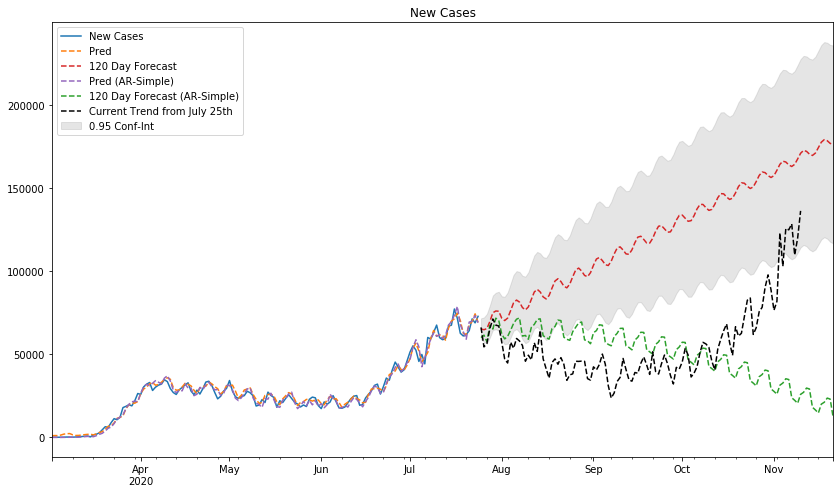

In [28]:
fig, ax=plt.subplots(1,1,figsize=(14,8))
y.plot(ax=ax);
pred.plot(ax=ax, style=['C1--']);
f_mean.plot(ax=ax, style=['C3--']);
pred_simple.plot(ax=ax, style=['C4--']);
forecast_simple.plot(ax=ax, style=['C2--']);
curr_trend.plot(ax=ax, style=['k--']);
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=.2);
plt.legend(['New Cases','Pred','{} Day Forecast'.format(days_to_forecast),
            'Pred (AR-Simple)','{} Day Forecast (AR-Simple)'.format(days_to_forecast),
            'Current Trend from July 25th',
            '0.95 Conf-Int'], loc='upper left');
plt.title("New Cases");

**As of 2020-11-07, the *simpler* model I created is way off base compared to actuals, where as the auto arima, while significantly linear, appears to catch where the actuals are headed.**

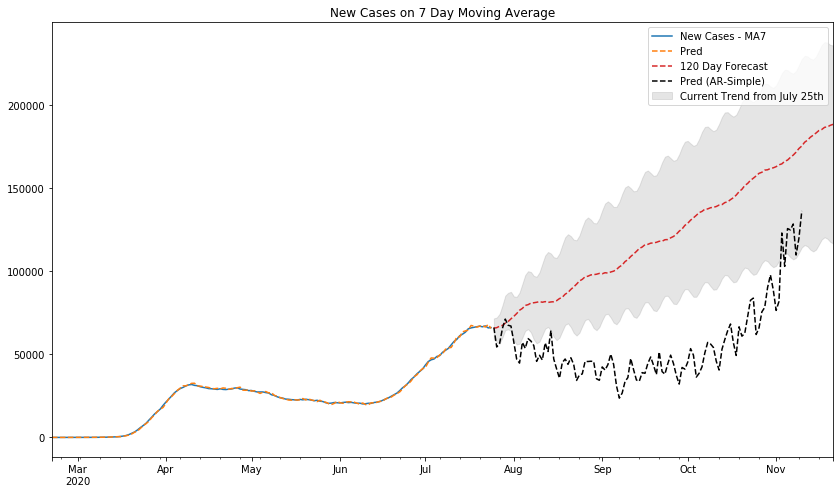

In [30]:
fig, ax=plt.subplots(1,1,figsize=(14,8))
y7.plot(ax=ax);
ma7_pred.plot(ax=ax, style=['C1--']);
ma7_mean.plot(ax=ax, style=['C3--']);
curr_trend.plot(ax=ax, style=['k--']);
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='gray', alpha=.2);
plt.legend(['New Cases - MA7','Pred','{} Day Forecast'.format(days_to_forecast),
            'Pred (AR-Simple)','Current Trend from July 25th'.format(days_to_forecast)]);
plt.title("New Cases on 7 Day Moving Average");

The moving average model is a smoother looking version of the ARIMA forecast.

In [61]:
usc.head()

us_cases  new_cases
2020-01-22         1        NaN
2020-01-23         1        0.0
2020-01-24         2        1.0
2020-01-25         2        0.0
2020-01-26         5        3.0

In [78]:
ma7_pred.cumsum()

2020-02-21    3.578704e+01
2020-02-22    4.724404e+01
2020-02-23    5.432891e+01
2020-02-24    6.211587e+01
2020-02-25    7.198760e+01
                  ...     
2020-07-20    3.628063e+06
2020-07-21    3.695357e+06
2020-07-22    3.761813e+06
2020-07-23    3.829758e+06
2020-07-24    3.895389e+06
Freq: D, Length: 155, dtype: float64

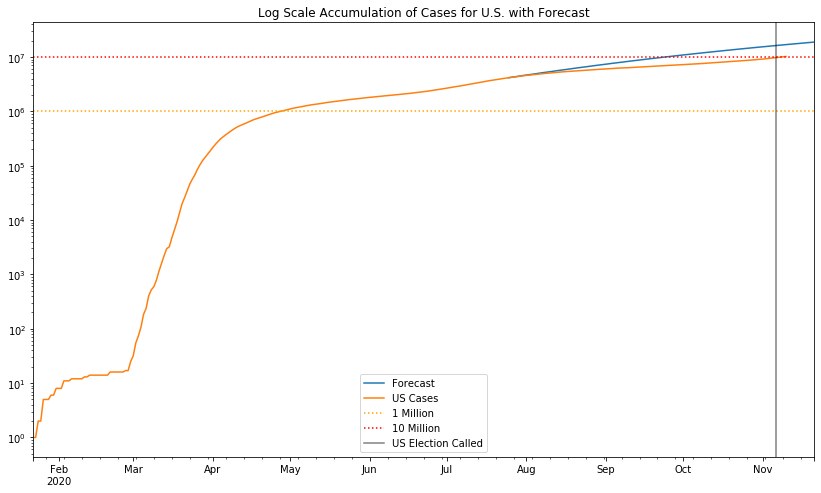

In [84]:
fig, ax=plt.subplots(1,1,figsize=(14,8))
# (y7.cumsum() + usc.us_cases.loc[:'2020-03-01'].sum()).plot(ax=ax);
(f_mean.cumsum() + usc.us_cases.loc['2020-07-24']).plot(ax=ax);
usc.us_cases.plot(ax=ax);
ax.set_title("Log Scale Accumulation of Cases for U.S. with Forecast");
ax.axhline(1e6, color='orange', ls=':')
ax.axhline(1e7, color='r', ls=':')
ax.axvline('2020-11-06', color='k', alpha=0.5);
ax.set_yscale("log");
ax.legend(['Forecast','US Cases','1 Million','10 Million','US Election Called']);

### Some Metrics

In [31]:
from sklearn.metrics import mean_squared_error

In [32]:
rmse = np.sqrt(mean_squared_error(curr_trend.dropna(), f_mean.loc['2020-07-25':curr_trend.dropna().index[-1]]))

print("RMSE for Forecast and Actuals = {:.3f} ".format(rmse))

RMSE for Forecast and Actuals = 66618.882 


**some of these notes are past notes through development - I should have dated them**


- Our prediction appears to fit the actual data well.
- The forecast clearly follows within the 7 day trend of spikes and drops from the weekend, but is not nearly as varianced as what will likely occur.
- The trend of the forecast continues upward although not at the pace are actually experiencing.
- The 7/14 (Simple) model has a significantly higher trend.
- A next step would be to add the confidence interval for the forecast.

- **We know how the trend continues from this point however our error is poor when estimating the model and stopping at July 24th.**.

**There are other methods that we can use to forecast, such as incorporating seasonality. We could also try to predict on moving averages of 7 days to attempt to smooth out the *seasonality* that is evident.**

### Adding to DataPane

In [33]:
import datapane as dp
import plotly.express as px
import plotly.graph_objects as go

In [34]:
print("Conf Int Head")
ci.head().style.format("{:,.0f}")

Conf Int Head


In [35]:
plot_df = pd.DataFrame(y)
plot_df['Arima_212_Pred'] = pred
# plot_df['Arima_212_Forc'] = f_mean
plot_df = pd.concat([plot_df,f_mean], axis=0)
plot_df.columns = ['Arima_212_Forc','Arima_212_Pred','US_Cases']
# plot_df['Arima_7_14_Pred'] = pred_714
# plot_df['Arima_7_14_Forc'] = forecast_714
plot_df['Arima_212_lci'] = ci['lower us_cases']
plot_df['Arima_212_uci'] = ci['upper us_cases']
plot_df['Current (from 7/25)'] = curr_trend.dropna()


In [36]:
plot_df.head()

Arima_212_Forc  Arima_212_Pred  US_Cases  Arima_212_lci  \
2020-03-02             NaN      943.907082      23.0            NaN   
2020-03-03             NaN     1052.859190      19.0            NaN   
2020-03-04             NaN     1006.933173      33.0            NaN   
2020-03-05             NaN     1340.594751      77.0            NaN   
2020-03-06             NaN     1896.842967      53.0            NaN   

            Arima_212_uci  Current (from 7/25)  
2020-03-02            NaN                  NaN  
2020-03-03            NaN                  NaN  
2020-03-04            NaN                  NaN  
2020-03-05            NaN                  NaN  
2020-03-06            NaN                  NaN

In [37]:
plot_df.tail()

Arima_212_Forc  Arima_212_Pred  US_Cases  Arima_212_lci  \
2020-11-17   177674.543208             NaN       NaN  119164.590006   
2020-11-18   179218.338574             NaN       NaN  120484.307179   
2020-11-19   178565.106866             NaN       NaN  119580.216302   
2020-11-20   176952.920032             NaN       NaN  117684.975889   
2020-11-21   176341.426225             NaN       NaN  116779.464592   

            Arima_212_uci  Current (from 7/25)  
2020-11-17  236184.496410                  NaN  
2020-11-18  237952.369969                  NaN  
2020-11-19  237549.997430                  NaN  
2020-11-20  236220.864175                  NaN  
2020-11-21  235903.387857                  NaN

In [38]:
plot_name = 'Covid19 - New Cases and Forecast for U.S.'

fig = go.Figure()
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Arima_212_uci'],showlegend=True,name='Upper CI',
                         line = dict(color='gray', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Arima_212_lci'],showlegend=True,name='Lower CI',
                         line = dict(color='gray', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['US_Cases'],showlegend=True,name='New Cases',
                         line = dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Arima_212_Pred'],showlegend=True,name='Prediction',
                         line = dict(color='red', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Arima_212_Forc'],showlegend=True,name='Forecast',
                         line = dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=plot_df.index,y=plot_df['Current (from 7/25)'],showlegend=True,name='Current From 7/25',
                         line = dict(color='black', width=2)))
fig.update_layout(title='SARIMA (1,1,0)x(1,0,1,7) on Covid19 New Cases for U.S.',
                   xaxis_title='Day',
                   yaxis_title='Count of New Cases')

fig.show()

In [39]:
r = dp.Report(dp.Plot(fig))
r.save(path='covid_plot.html', open=True)

In [40]:
help(r.publish)

Help on method publish in module datapane.client.api.report:

publish(name: str, description: str = '', open: bool = False, tags: list = None, tweet: Union[bool, str] = False, source_url: str = '', **kwargs) method of datapane.client.api.report.Report instance
    Deploy the report and its Assets to Datapane



In [41]:
r.publish(name='covid19_us_new_cases_forecast', str="New_Cases_Forecast_From_July25")

Publishing report and associated data - please wait..
Report successfully published at https://datapane.com/u/dex314/reports/covid19-us-new-cases-forecast/


### New Deaths

In [42]:
yd = usd.us_deaths.loc['2020-03-01':'2020-07-24'].diff().dropna()

## we will start deaths 14 days later than cases (or not)

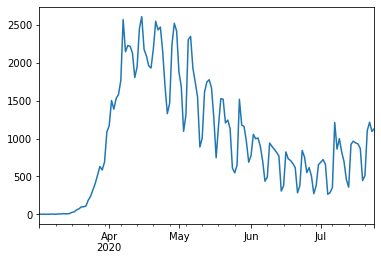

In [43]:
yd.plot()

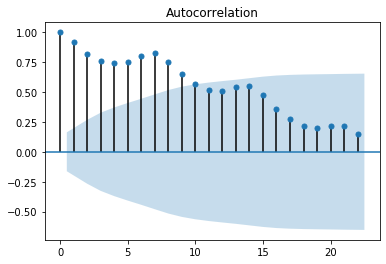

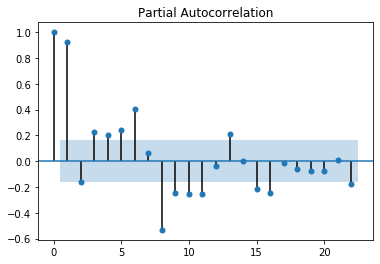

In [44]:
sma.tsa.graphics.plot_acf(yd);
sma.tsa.graphics.plot_pacf(yd);

The deaths have similar correlation to the cases but also at more lags.

In [45]:
## were making a few adjustments here
arimad = pmd.auto_arima(y=yd, max_p=24, max_d=1, max_q=24, seasonal = True, m=7, out_of_sample_size=14)
print(arimad.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  145
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 7)   Log Likelihood                -965.765
Date:                             Wed, 11 Nov 2020   AIC                           1943.531
Time:                                     10:20:45   BIC                           1961.350
Sample:                                          0   HQIC                          1950.771
                                             - 145                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2475      6.625      0.188      0.851     -11.737      14.232
ma.L1         -0.2628      

There are alot of similarities between deaths and cases which isnt surprising I guess. 

                                      SARIMAX Results                                      
Dep. Variable:                           us_deaths   No. Observations:                  145
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 7)   Log Likelihood                -964.774
Date:                             Wed, 11 Nov 2020   AIC                           1943.549
Time:                                     10:20:45   BIC                           1964.337
Sample:                                 03-02-2020   HQIC                          1951.996
                                      - 07-24-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3468      5.628      0.239      0.811      -9.684      12.378
ma.L1         -0.2130      

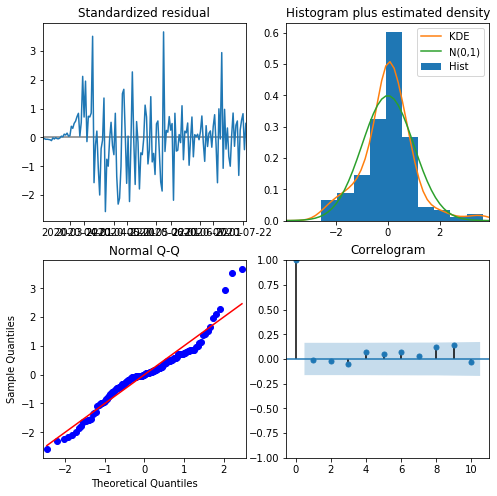

In [46]:
modd = sma.tsa.SARIMAX(endog=yd, order=(0,1,3), seasonal_order=(1,0,1,7), trend='c')
fitd = modd.fit()
print(fitd.summary())
fitd.plot_diagnostics(figsize=(8,8));

<s>Our final model for deaths is not as useful. We lose a lot of traction in the variables and its likely because we miss the jump in deaths in June.</s>

The data was updated and there is no longer a June jump.

In [47]:
## Lets forecast out a month based on this data
forecastd = fitd.forecast(days_to_forecast)
predd = fitd.predict()

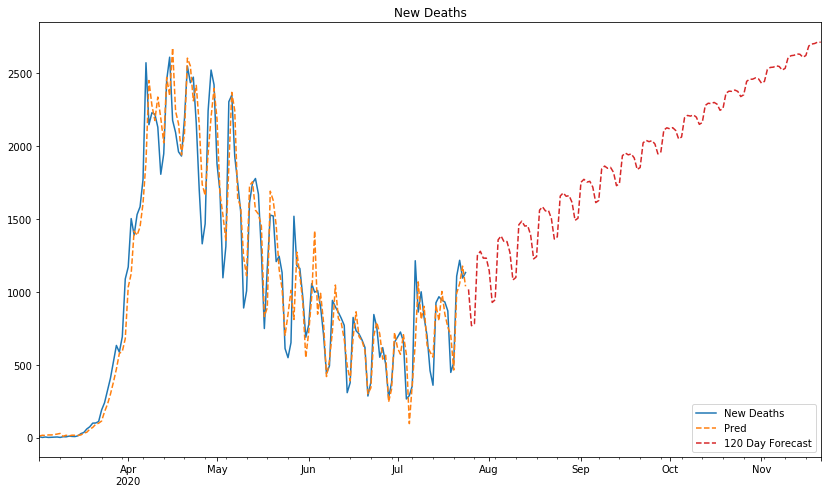

In [48]:
fig, ax=plt.subplots(1,1,figsize=(14,8))
yd.plot(ax=ax);
predd.plot(ax=ax, style=['C1--']);
forecastd.plot(ax=ax, style=['C3--']);
plt.legend(['New Deaths','Pred','{} Day Forecast'.format(days_to_forecast)]);
plt.title("New Deaths");

The model is re-estimated and shows increasing deaths.

### STUMPY

- https://github.com/TDAmeritrade/stumpy

I stumbled on this through the internet but essentially it is another tool at our disposal for examining time series. The basic idea is that you take your time series, select a window of points which slides across the data set one point at a time. At the same time, another window of the same size slides across and calculates the *Euclidean Distance* (magnitude) of that steady window and the second sliding window. It creates a matrix of values that are useful to us called the *matrix profile*.

In this matrix profile, the minima can tell us about motifs (repeating patters) and the maxima can tell us about outliers.

In [49]:
window = 7
mp = stumpy.stump(y, m=window)

In [50]:
mp.shape

(139, 4)

In [51]:
mp_df = pd.DataFrame(mp, columns=['matrix_profile','profile_indices','left_idx','right_idx'],
                     index = y.index[:len(mp)])
mp_df = pd.concat([y, mp_df], axis=1)

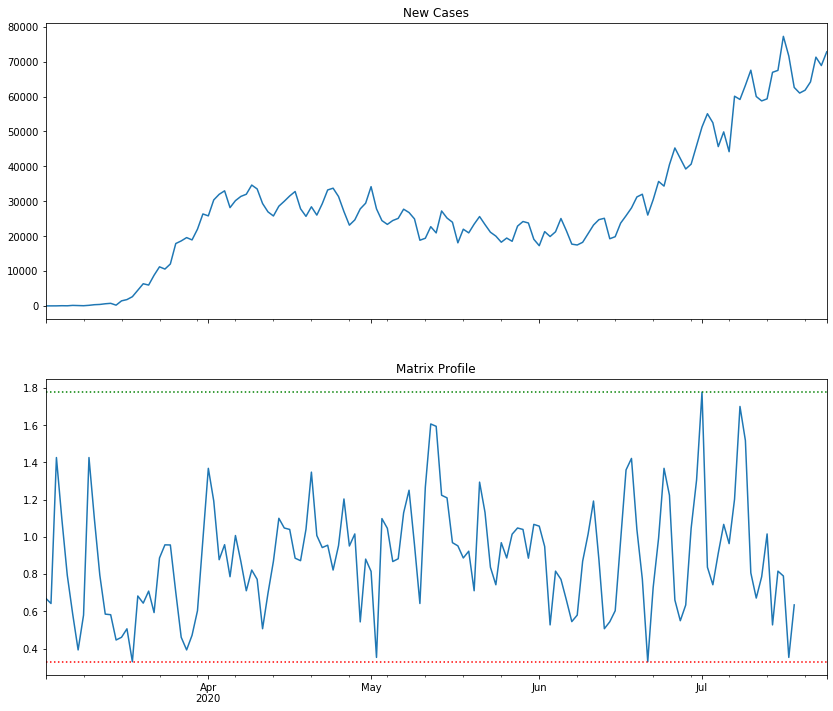

In [52]:
fig, ax=plt.subplots(2,1,figsize=(14,12), sharex=True)
mp_df.us_cases.plot(ax=ax[0]);
mp_df.matrix_profile.plot(ax=ax[1]);
ax[1].axhline(mp_df.matrix_profile.min(), color='r', ls=':');
ax[1].axhline(mp_df.matrix_profile.max(), color='g', ls=':');
ax[0].set_title("New Cases");
ax[1].set_title("Matrix Profile");

In [53]:
print(mp_df.matrix_profile.min())
print(mp_df.matrix_profile.max())

0.32925798656183897
1.777976685055769


Our minimum appears to hit two points and they also appear to be 7 days apart which is interesting considering we have the type of seasonality. The motif there only happens twice however so there may not be significant repeating patters, which we mostly already know.


Our maximums tell us another story though. Specifically that middle max in the middle of May. This could likely have been the first instance of states "opening" back up. This should have been our first hint at how things were likely going to go.

**Update: The new maximum in July highlights what may have been the peak of the second peak.**

In [54]:
mp_df[mp_df.matrix_profile < 0.28]

Empty DataFrame
Columns: [us_cases, matrix_profile, profile_indices, left_idx, right_idx]
Index: []

In [55]:
mp_df[mp_df.matrix_profile > 1.6]

us_cases matrix_profile profile_indices left_idx right_idx
2020-05-12   22721.0        1.60706              64       64       134
2020-07-01   51288.0        1.77798              81       81       128
2020-07-08   59175.0         1.7012             114      114       135

The maximum points and closest neighbors are not evenly spaced though.

**The lastest data gives us three minima now highlight we have hit three different points in this that are similar and possibly repeating.**

There may be more insight we can glean from the matrix profile, visually I see points at the end of Aril that appear to have somme sort of motif within them. For now we are going to leave it at this.